In [1]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import IPython.display as ipd
import soundfile as sf
from joblib import Parallel, delayed

In [2]:
plt.style.use("dark_background")
plt.rcParams.update({
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.color": "gray",
    "grid.alpha": 0.6,
    "axes.labelcolor": "white",  
    "xtick.color": "white",     
    "ytick.color": "white"       
})

## Exploring metadata

In [3]:
DATA_PATH = Path("../data/AudioMNIST")

In [4]:
with open(DATA_PATH / "audioMNIST_meta.txt", "r", encoding="utf-8") as file:
    data = json.load(file)  

df = pd.DataFrame.from_dict(data, orient="index")
df["recordingdate"] = pd.to_datetime(df["recordingdate"], format="%y-%m-%d-%H-%M-%S")
df["age"] = df["age"].astype(int)
df["accent"] = df["accent"].str.lower()
df["recordingroom"] = df["recordingroom"].str.lower().replace("vr-romm", "vr-room", regex=False)

df.head()

,accent,age,gender,native speaker,origin,recordingdate,recordingroom
01,german,30,male,no,"Europe, Germany, Wuerzburg",2017-06-22 11:04:28,kino
02,german,25,male,no,"Europe, Germany, Hamburg",2017-06-26 17:57:29,kino
03,german,31,male,no,"Europe, Germany, Bremen",2017-06-30 17:34:51,kino
04,german,23,male,no,"Europe, Germany, Helmstedt",2017-06-30 18:09:14,kino
05,german,25,male,no,"Europe, Germany, Hameln",2017-07-06 10:53:10,kino


In [5]:
df.describe(include="all")

,accent,age,gender,native speaker,origin,recordingdate,recordingroom
count,60,60.000000,60,60,60,60,60
unique,16,NaN,2,2,42,NaN,4
top,german,NaN,male,no,"Europe, Germany, Berlin",NaN,vr-room
freq,41,NaN,48,57,15,NaN,35
mean,NaN,48.083333,NaN,NaN,NaN,2017-08-19 04:10:32.583333632,NaN
min,NaN,22.000000,NaN,NaN,NaN,2017-06-22 11:04:28,NaN
25%,NaN,25.000000,NaN,NaN,NaN,2017-07-29 23:44:30.500000,NaN
50%,NaN,27.000000,NaN,NaN,NaN,2017-08-21 11:54:12.500000,NaN
75%,NaN,30.000000,NaN,NaN,NaN,2017-09-11 14:07:33.750000128,NaN
max,NaN,1234.000000,NaN,NaN,NaN,2017-10-20 17:24:39,NaN


In [6]:
df[df["age"] < 100]["age"].describe()

count    59.000000
mean     27.983051
std       5.811675
min      22.000000
25%      25.000000
50%      27.000000
75%      30.000000
max      61.000000
Name: age, dtype: float64

In [7]:
index_old = df[df["age"] > 100].index[0]
old_man_path = DATA_PATH / f"{index_old}/"
wav_files = list(old_man_path.glob("*.wav"))
random_file = np.random.choice(wav_files) 

ipd.Audio(str(random_file))

idk, sounds like 25

In [8]:
df["accent"].value_counts()

accent
german                41
chinese                3
spanish                2
italian                2
south korean           1
madras                 1
levant                 1
german/spanish         1
english                1
brasilian              1
egyptian_american?     1
south african          1
arabic                 1
danish                 1
french                 1
tamil                  1
Name: count, dtype: int64

In [9]:
df["recordingroom"].value_counts()

recordingroom
vr-room     35
kino        19
ruheraum     3
library      3
Name: count, dtype: int64

In [10]:
df["recordingdate"].max() - df["recordingdate"].min()

Timedelta('120 days 06:20:11')

## Audio files

In [11]:
audio_files = list(DATA_PATH.glob("*/*.wav"))

In [12]:
s, srate = librosa.load(audio_files[-1])
print(s.shape)
print(srate)

(15759,)
22050


In [13]:
if False:
    def process_audio(file):
        s, srate = sf.read(file) 
        return (
            file.name, 
            s.shape[0], 
            srate, 
            s.shape[0] / srate, 
            np.mean(np.abs(s)), 
            np.mean(librosa.feature.rms(y=s)), 
            np.mean(librosa.feature.zero_crossing_rate(y=s)),
            np.var(librosa.feature.zero_crossing_rate(y=s)),
            np.mean(librosa.feature.spectral_centroid(y=s, sr=srate)),
            np.mean(librosa.feature.spectral_bandwidth(y=s, sr=srate)),
            np.mean(librosa.feature.spectral_flatness(y=s)) 
        )

    audio_stats = Parallel(n_jobs=-1, backend="loky")(
        delayed(process_audio)(file) for file in audio_files
        )

    audio_df = pd.DataFrame(
        audio_stats, 
        columns=["filename", "shape", "sample_rate", "duration", "mean_amplitude", "rms", "zero_crossing_rate",
                "zcr_variance", "spectral_centroid", "spectral_bandwidth", "spectral_flatness"]
        )

    audio_df["digit"] = audio_df["filename"].str.split("_").str.get(0).astype(int)
    audio_df["digit"] = audio_df["digit"].astype(int)
    audio_df["speaker"] = audio_df["filename"].str.split("_").str.get(1)
    audio_df["sample_number"] = audio_df["filename"].str.extract(r"_(\d+)\.wav$").astype(int)
    audio_df["speaker_int"] = audio_df["speaker"].astype(int)
    audio_df.sort_values(by=["digit", "speaker_int", "sample_number"], inplace=True)
    audio_df.drop(columns=["speaker_int"], inplace=True)
    audio_df.reset_index(drop=True, inplace=True)

    dfcols = audio_df.columns
    new_order = list(dfcols[:1]) + list(dfcols[-3:]) + list(dfcols[1:-3])
    audio_df = audio_df[new_order]

    del audio_stats, dfcols, new_order

    audio_df.to_csv(DATA_PATH / "audio_dataframe.csv", index=False)

Cols:

- `mean_amplitude`: average sense of loudness
- `rms`: root mean square, more accurate semi-metric of power/loudness
- `zero_crossing_rate`: sign change rate, texture metric. Higher values may indicate percussive, noisy sound, higher frequencies. Lower values may indicate smoother sound
- `zcr_variance`: variance of zero crossing rate. May indicate rapid changes in the signal
- `spectral_centroid`: brightness as center of mass. Higher - brighter, sharp. Lower - dim, darker sound
- `spectral_bandwidth`: width of spectrum. Higher - noisy/complex sound. Lower - pure, tonal sound
- `sceptral_flatness`:  similar to centroid and sign change rate

In [14]:
audio_df = pd.read_csv(DATA_PATH / "audio_dataframe.csv", dtype={"speaker": str})
audio_df.describe()

,digit,sample_number,shape,sample_rate,duration,mean_amplitude,rms,zero_crossing_rate,zcr_variance,spectral_centroid,spectral_bandwidth,spectral_flatness
count,30000.000000,30000.00000,30000.000000,30000.0,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,4.500000,24.50000,30844.475533,48000.0,0.642593,0.002546,0.003182,0.062992,0.005407,4058.023805,4868.591724,0.016947
std,2.872329,14.43111,5334.715104,0.0,0.111140,0.002250,0.002889,0.040328,0.005722,1018.696213,516.668387,0.014492
min,0.000000,0.00000,14073.000000,48000.0,0.293187,0.000286,0.000371,0.002373,0.000002,691.734376,2244.681683,0.000041
25%,2.000000,12.00000,26909.750000,48000.0,0.560620,0.001479,0.001840,0.033330,0.000871,3373.861088,4520.569060,0.006539
50%,4.500000,24.50000,30336.000000,48000.0,0.632000,0.002044,0.002538,0.052821,0.003315,3958.868424,4879.086363,0.012857
75%,7.000000,37.00000,34380.000000,48000.0,0.716250,0.002892,0.003622,0.080205,0.008410,4616.707006,5236.391739,0.023138
max,9.000000,49.00000,47998.000000,48000.0,0.999958,0.034160,0.044059,0.255576,0.046836,7994.220095,6694.981803,0.123889


## Checking audio variability in dataset

In [15]:
def compare_extrema(col_name, df = audio_df):
    min_file = df.iloc[df[col_name].idxmin(), 0]
    max_file = df.iloc[df[col_name].idxmax(), 0]
    min_path = DATA_PATH / min_file.split(sep="_")[1] / min_file
    max_path = DATA_PATH / max_file.split(sep="_")[1] / max_file
    
    s1, sr = librosa.load(min_path, sr=None)
    s2, _ = librosa.load(max_path, sr=None)
    
    fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharey=True)
    librosa.display.waveshow(s1, sr=sr, ax=axs[0])
    librosa.display.waveshow(s2, sr=sr, ax=axs[1])
    
    axs[0].set_title(f"File: {min_file} | Min {col_name}: {df[col_name].min():.4f}")
    axs[1].set_title(f"File: {max_file} | Max {col_name}: {df[col_name].max():.4f}")
    axs[0].set_xlabel("Time (s)")
    axs[0].set_ylabel("Amplitude")
    axs[1].set_xlabel("Time (s)")
    plt.suptitle(f"Extrema waveforms for {col_name}", fontsize=16)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()
    
    print("Min sample:")
    display(ipd.Audio(min_path))
    print("Max sample:")
    display(ipd.Audio(max_path))

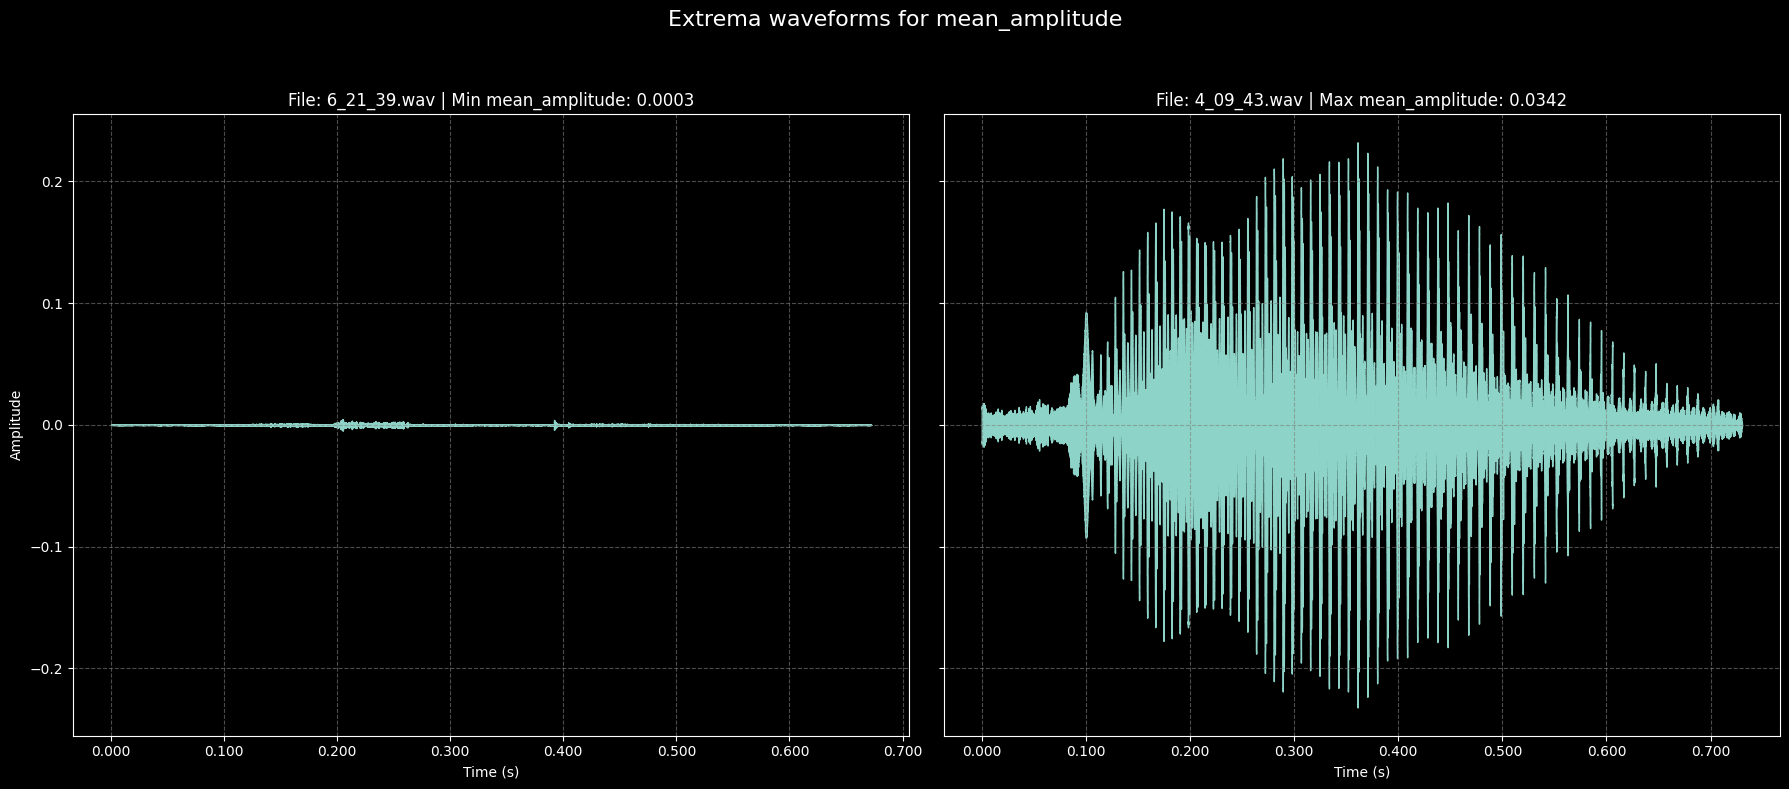

Min sample:


Max sample:


In [16]:
compare_extrema("mean_amplitude")

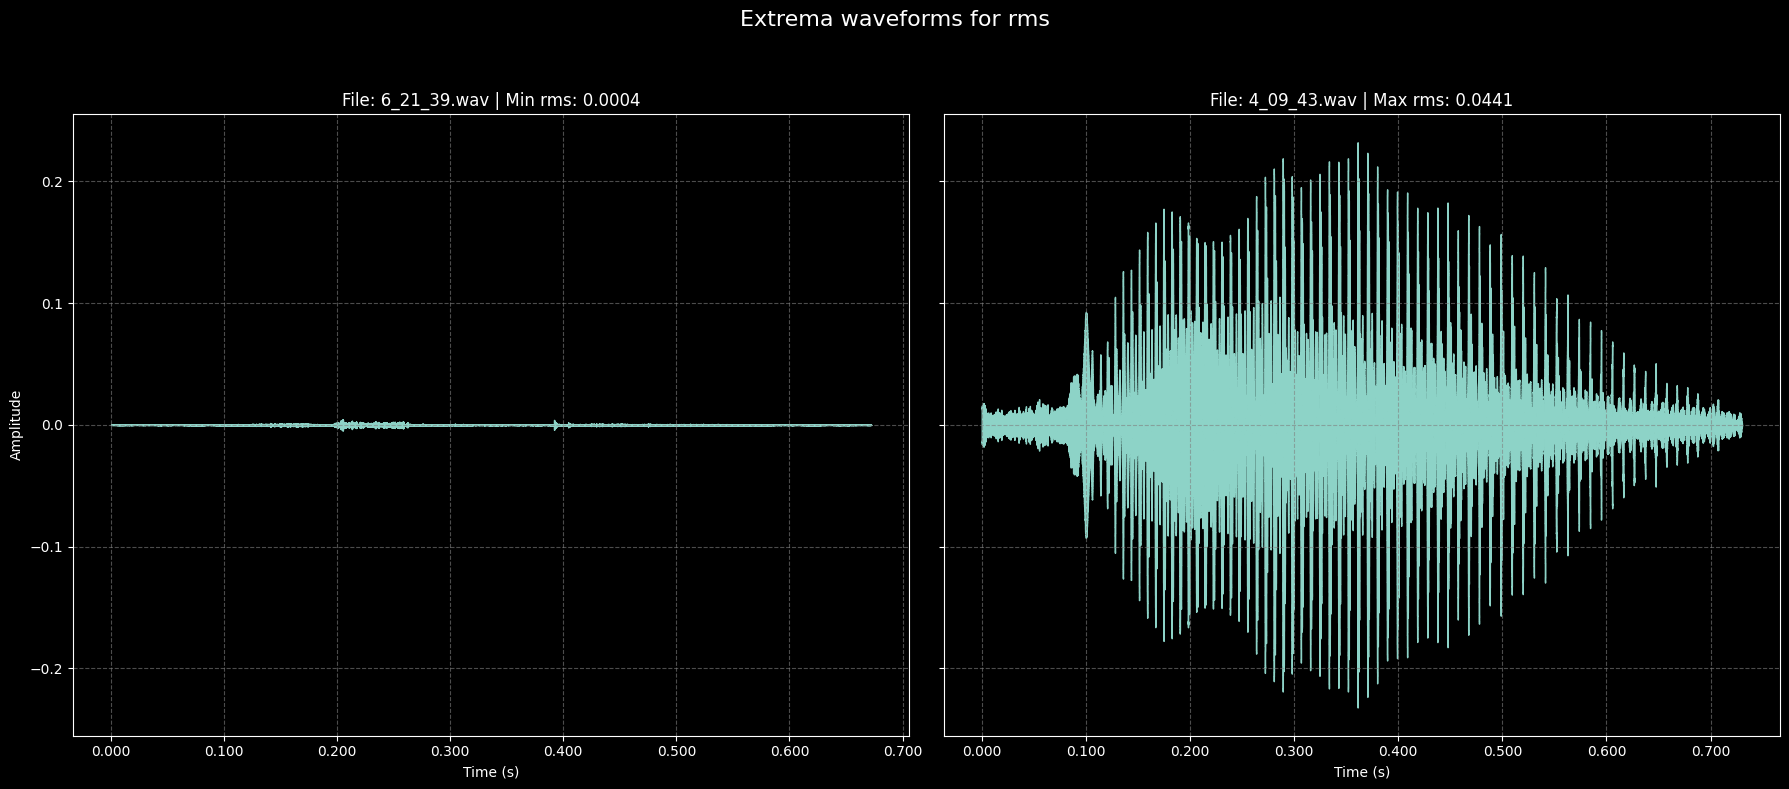

Min sample:


Max sample:


In [17]:
compare_extrema("rms")

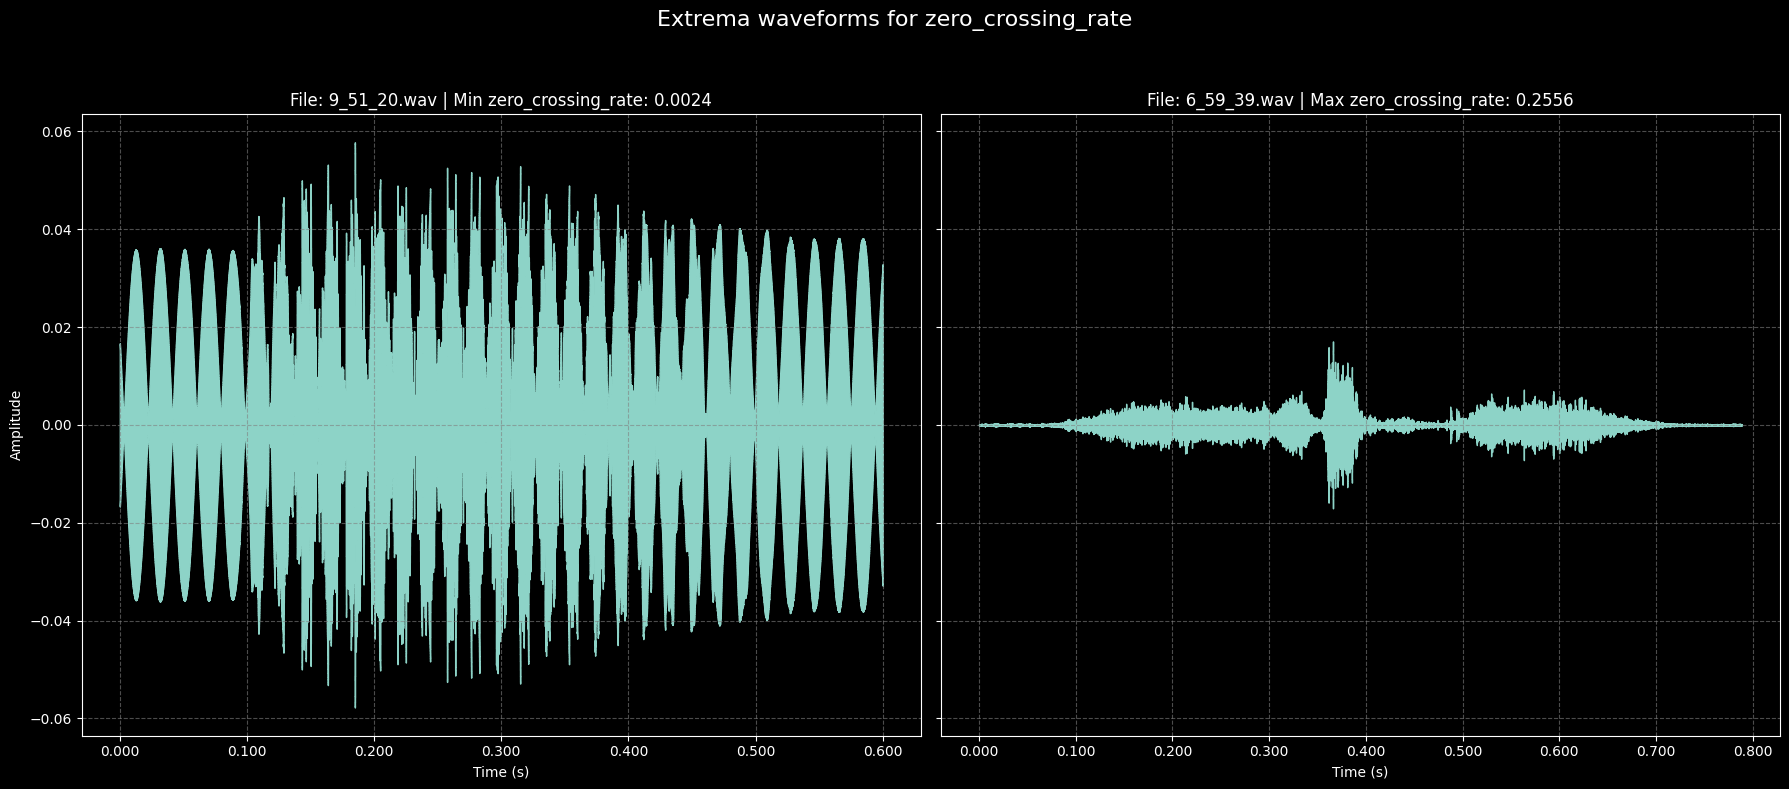

Min sample:


Max sample:


In [18]:
compare_extrema("zero_crossing_rate")

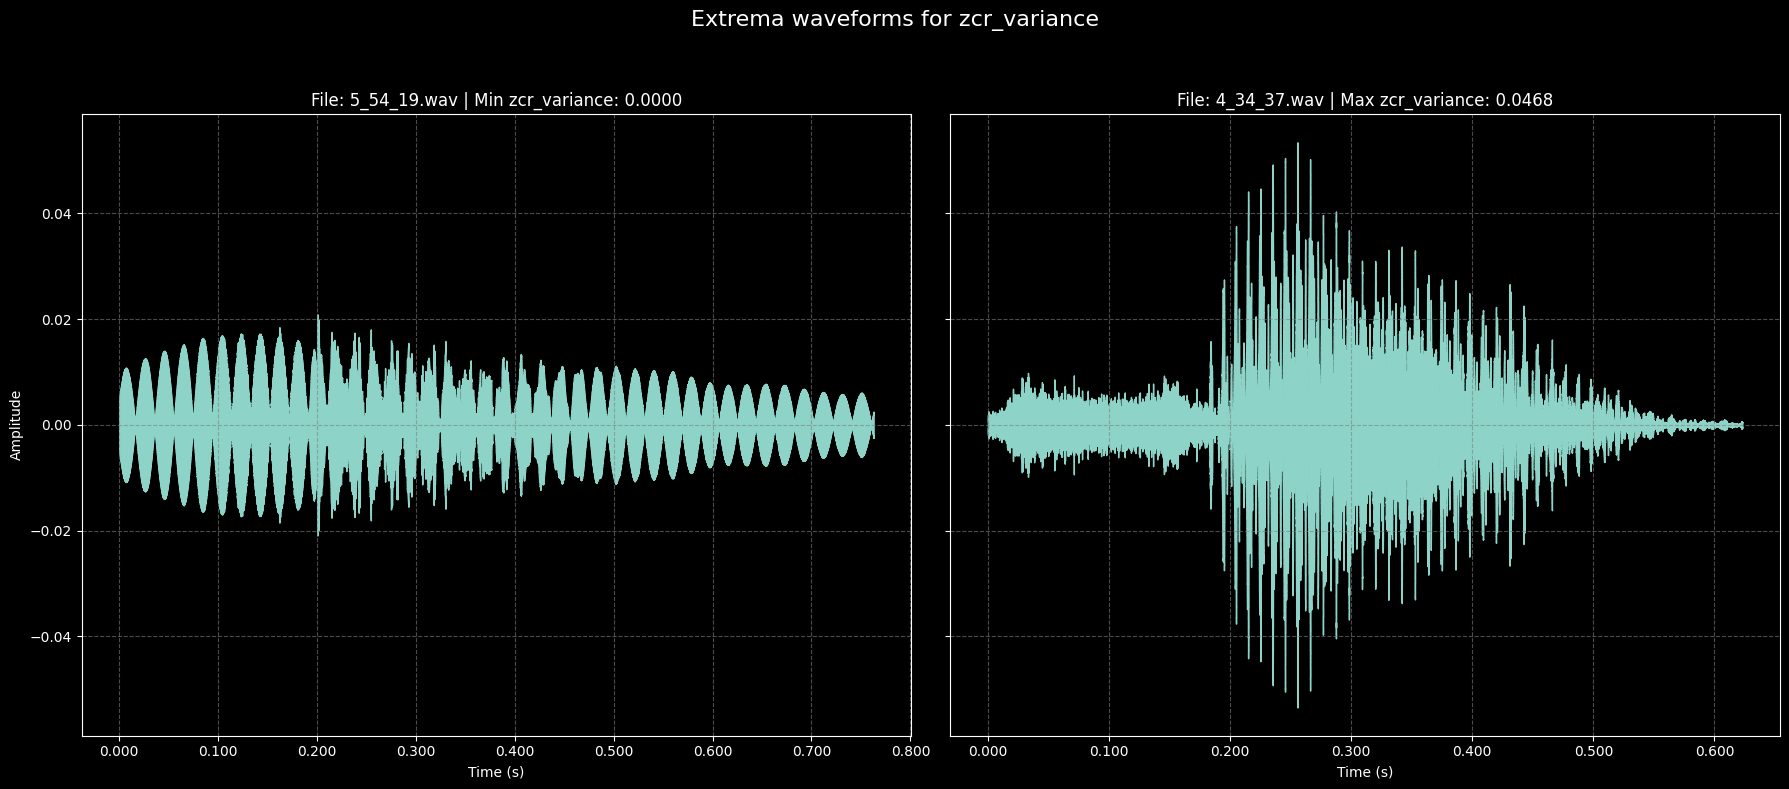

Min sample:


Max sample:


In [19]:
compare_extrema("zcr_variance")

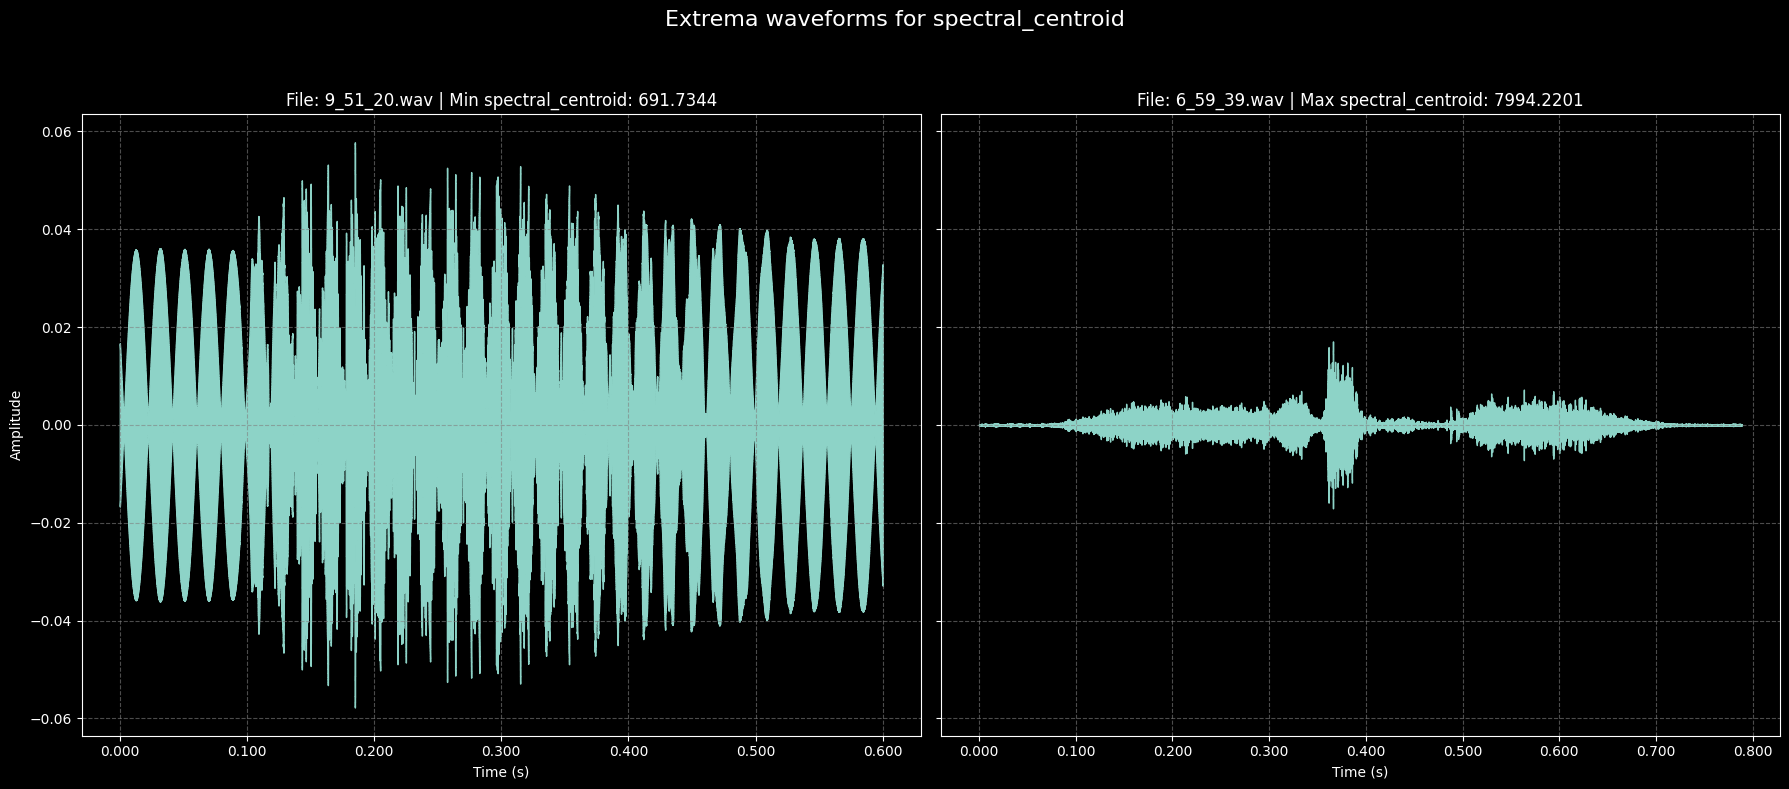

Min sample:


Max sample:


In [20]:
compare_extrema("spectral_centroid")

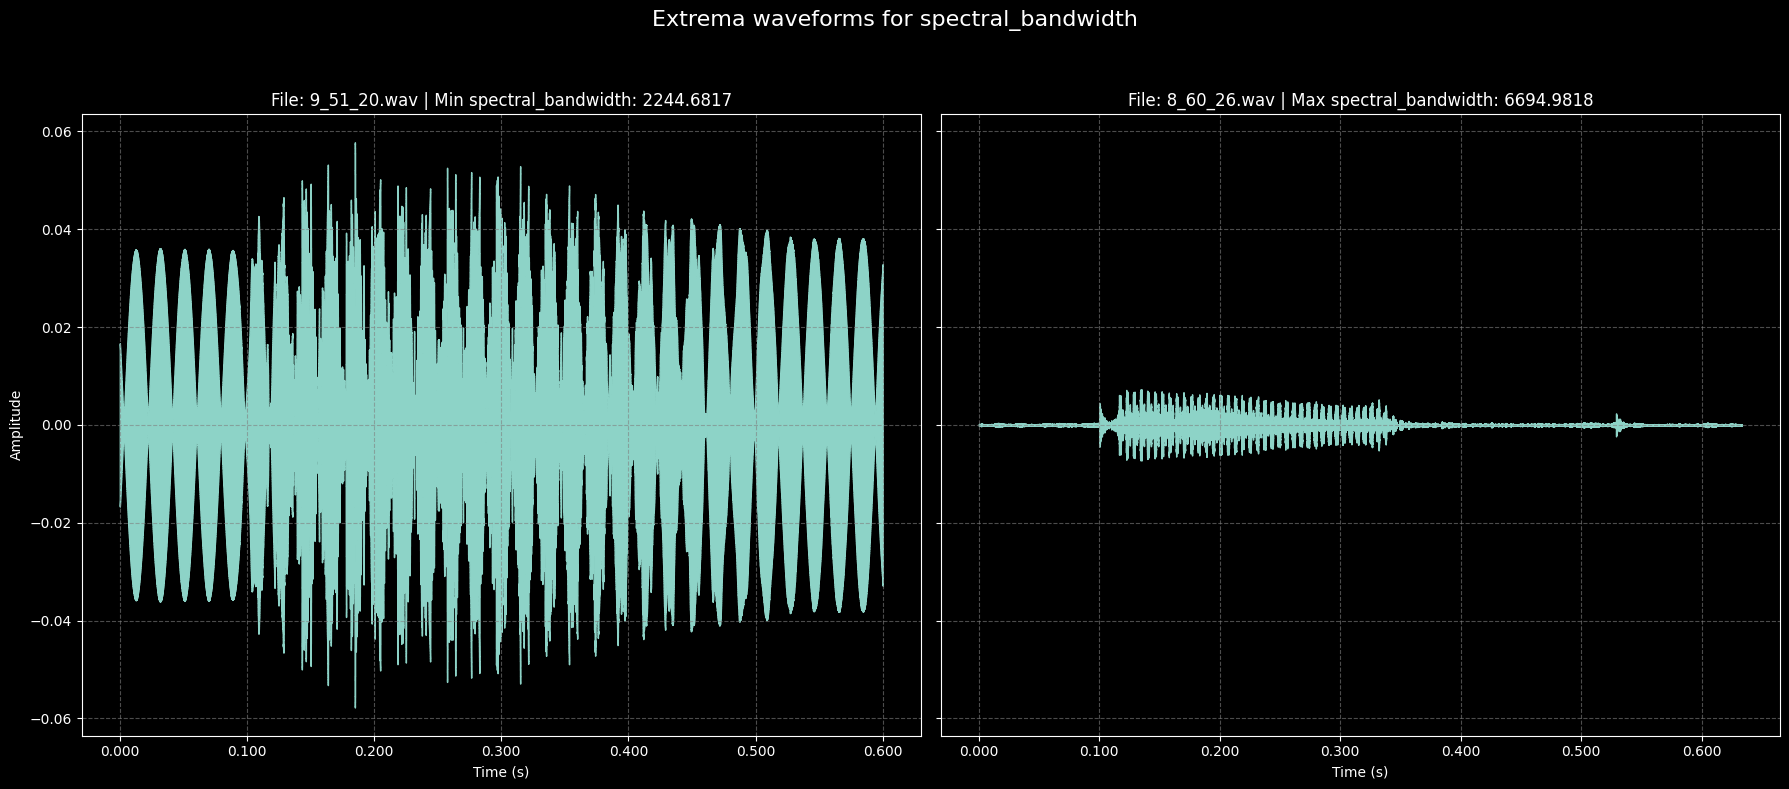

Min sample:


Max sample:


In [21]:
compare_extrema("spectral_bandwidth")

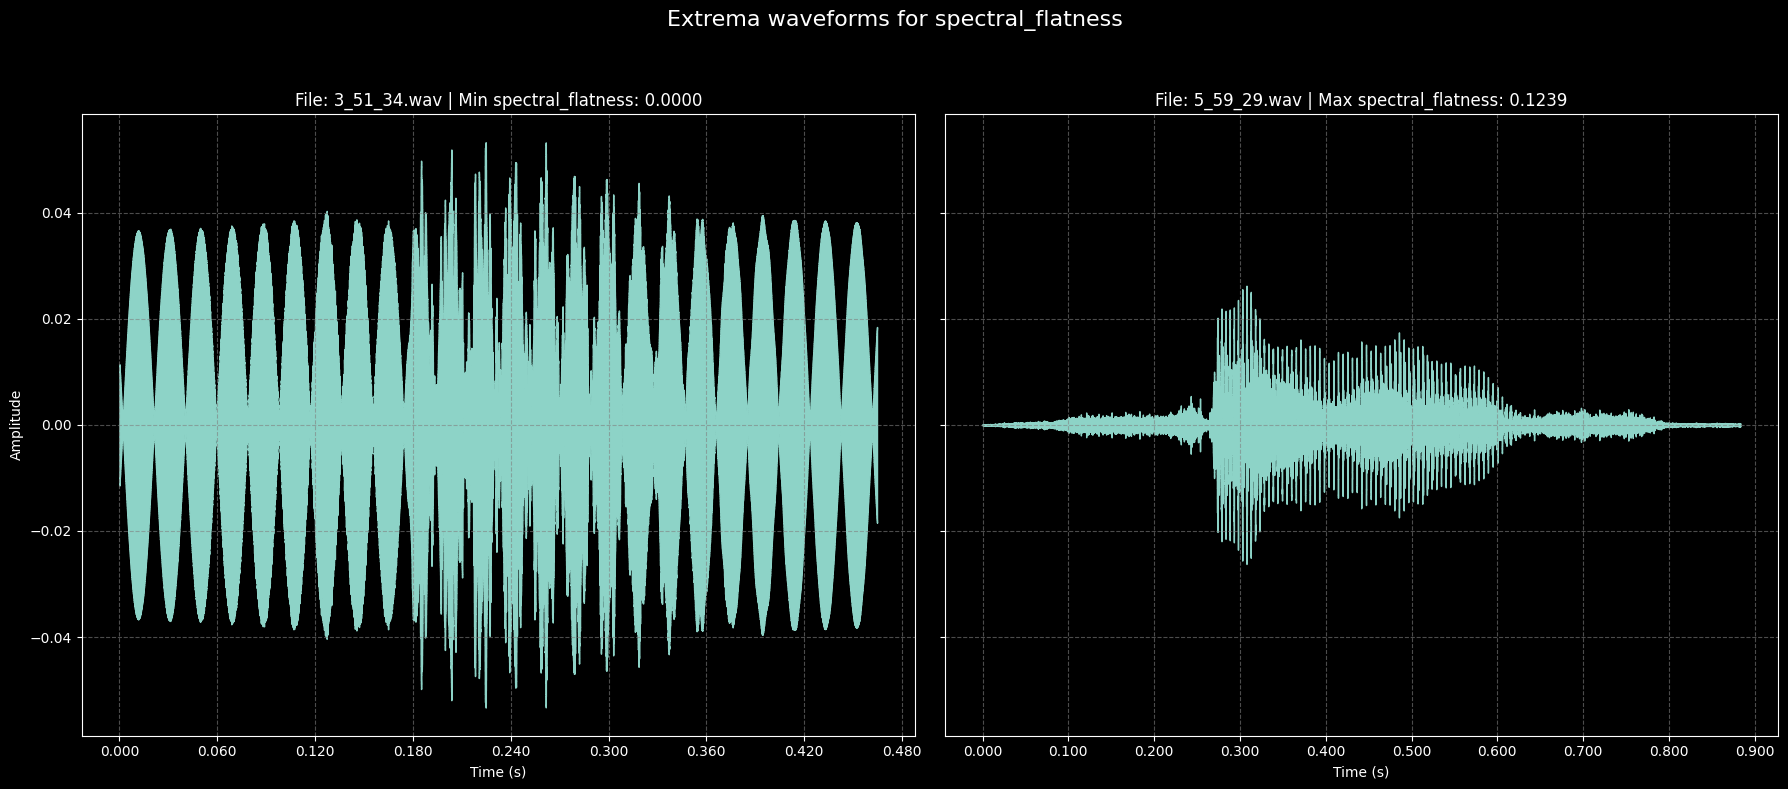

Min sample:


Max sample:


In [22]:
compare_extrema("spectral_flatness")